In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torchvision
import torch.nn as nn                                                
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
from IPython.display import clear_output
from torchvision.transforms import ToTensor
from numpy import random 
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from torch.optim.lr_scheduler import StepLR

In [15]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(7, 10, 5)
        
        
        self.fc1 = nn.Linear(280, 90)
        self.fc2 = nn.Linear(90, 30)
        self.fc3 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

drunk_driver = Net()
print(drunk_driver)
net = drunk_driver

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=280, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
)


20646   frames 


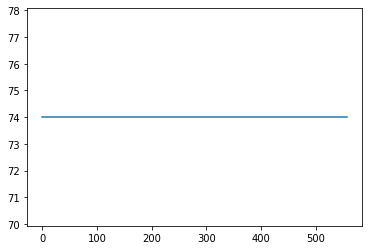

In [5]:

arr =  np.array(np.load("/content/drive/My Drive/kaggle/mind_the_bend/numpy/new_mirrored.npy",allow_pickle = True))
print(arr.shape[0], "  frames ")

def find_no_occ(arr, element):
    co = 0 
    for i in range(len(arr)):
        if arr[i][1] == element:
            co += 1
    return(co)

def check_for_balance(arr):
    dist = []
    for m in range(len(arr)):
        if arr[m][1] != arr[m-1][1]:
            no_occ = find_no_occ(arr, arr[m][1])
            dist.append(no_occ)
    return dist

dist = check_for_balance(arr)
plt.plot(dist)
plt.show()

In [0]:

def extract_column(arr, index):
  
    x_train = []
    for m in range (len(arr)):
        x_train.append(arr[m][index])
    return( np.array(x_train))
    
x_train = extract_column(arr,0)
y_train = extract_column(arr,1)

def vis_loss_multi(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()
    

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")

    plt.show()
    

def save_nn(filename):

    torch.save(drunk_driver, filename)
    print (" saved -- ", filename )      


In [21]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

full_dataset = TensorDataset(x_train_tensor, y_train_tensor)       ## make compatible with DataLoader 


train_size = int(0.9 * len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size=20, shuffle = True)

print(len(train_loader))
print(len(val_loader))

93
104


In [0]:
losses = []
val_losses = []
avg_losses = []
avg_val_losses = []


In [0]:
learning_rate = 0.001

In [0]:
def make_train_step(model, optimizer):

    def train_step(x, y):
        optimizer.zero_grad()
        pred = model(x)
        y = y.unsqueeze(1)
        y = y.float()
        loss = F.mse_loss(pred, y)
        loss.backward()
        optimizer.step()
        
        print ("|", end = "")
        return loss.item()
      
    return train_step

model = drunk_driver

def train_drunk_driver(train_loader, epochs, initial_lr):
    learning_rate = initial_lr
    
    optimizer = optim.Adam(drunk_driver.parameters(), learning_rate) 
    train_step = make_train_step(model, optimizer)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.969)  # lr decreases by 10% aftr every epoch
    train_valve = False
    for i in range(epochs):
        foo = optimizer.param_groups[0]['lr']
        print("training batches  --", end = "")
        for x_batch, y_batch in train_loader:

            model.train()
            loss = train_step(x_batch, y_batch)

            losses.append(loss)  ## metrics 

        with torch.no_grad():
            print ("")
            print ("running on validation set .", end = "" )
            for x_val, y_val in val_loader:
                y_val =  y_val.unsqueeze(1)
                y_val =  y_val.float()
                model.eval()
                yhat = model(x_val)  # pred 
                val_loss = F.mse_loss(yhat, y_val)

                val_losses.append(val_loss.item())  ## metrics 
                print (".", end = "")
        print ("")
        scheduler.step()   ## lr decay caller 
        clear_output()

        epoch_avg_loss = sum(losses[-104:])/104

        val_av_loss = sum(val_losses[-93:])/93
        
        avg_losses.append(epoch_avg_loss)
        avg_val_losses.append(val_av_loss)

        vis_loss_multi(losses, val_losses)

        print("recent state in the last 500 batches -- ")
        vis_loss_multi_colors(losses[-500:], val_losses[-500:])

        print ("epoch - ", i+1, "  current lr = ", foo,  " epoch_avg_loss = ", epoch_avg_loss, "  validation_average_loss = ", val_av_loss)


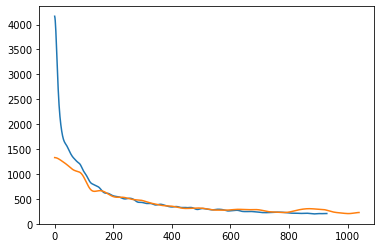

recent state in the last 500 batches -- 


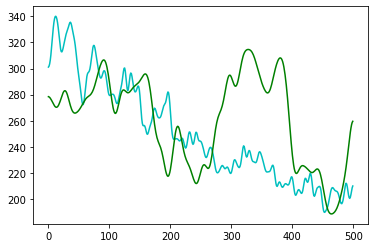

epoch -  10   current lr =  0.0007532063859404785  epoch_avg_loss =  205.96634321946365   validation_average_loss =  216.14069177771128


In [18]:
train_drunk_driver(train_loader, 10, initial_lr = 0.001) 
## need more training data 

In [19]:
save_nn("/content/drive/My Drive/kaggle/mind_the_bend/torch/alpha.pth")

 saved --  /content/drive/My Drive/kaggle/mind_the_bend/torch/alpha.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-p